In [35]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%matplotlib notebook




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import numpy
import scipy
import scipy.optimize
import math
import random
import os
import sys
#
import matplotlib
import pylab as plt
import matplotlib.dates as mpd
#
import libcomcat as comcat
#
#import libcomcat.utils
#from libcomcat.utils import get_phase_dataframe, get_summary_data_frame
#from libcomcat.utils import get_summary_data_frame
from libcomcat.search import search,count,get_event_by_id
from datetime import datetime
import os.path
import pandas as pd

In [37]:
eventlist = search(starttime=datetime(1990,1,17,12,30),
                       endtime=datetime(2017,1,18,12,35),
                       minmagnitude=3.0,
                      minlatitude=31., maxlatitude=42.,
                      minlongitude=-125., maxlongitude=-115)
#

In [129]:
#
catalog = [[ev.time, ev.latitude, ev.longitude, ev.magnitude, ev.depth, mpd.date2num(ev.time)] for ev in eventlist]
#
catalog = numpy.core.records.fromarrays(zip(*catalog), dtype=[('event_date', 'M8[us]'), 
          ('lat','f8'), ('lon','f8'), ('mag','f8'), ('depth','f8'), ('event_date_float', 'f8')])
print('catlen: ', len(eventlist))
#
eq_intervals = numpy.diff(catalog['event_date_float'])
#

ix_m7 = (catalog['mag']>7.)
M7s = catalog[ix_m7]

Text(0, 0.5, 'Interval $\\Delta t$')

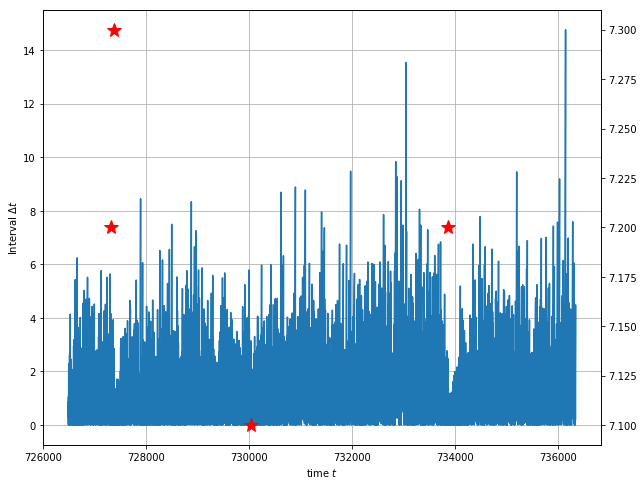

In [130]:
fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.grid()
ax1a = ax1.twinx()
#
ax1.plot(catalog['event_date_float'][1:], numpy.diff(catalog['event_date_float']), ls='-', marker='')
ax1a.plot(M7s['event_date_float'], M7s['mag'], marker='*', ls='', color='r', ms=15)
#
ax1.set_xlabel('time $t$')
ax1.set_ylabel('Interval $\Delta t$')
#ax1.set_yscale('log')

In [106]:
# now, we'll want to compute running entropy. instead of binning, let's use cumulative probabilities -- which
#  makes sense for earthquake intervals (from a physical perspective).
#
def entropy_cdf(X, invert=False):
    # entropy of the sequence X
    #
    # TODO: so it would be nice to use cumulative probabilities, not pdf "likelihood", since it (nominally) avoids
    #  the problem of bias-by-binning. on the other hand, the probabilities area always the same (P_k = k/N).
    #  so we could get around that by interpolating, say to N' = 10*N, or something like that. that would extract
    #  the shape of the distribution. generally, it looks like there is always some sort of subjective bias in
    #  entropy...
    #  The equivalent of this is width-weighted aggretation, so P = (P_k * \Delta x)/\Delta X . Note this is 
    #   equivalent to interpolating a bunch of points between (x_1, x_2). 
    #Ps = T
    # block out now; optimize later (consider only partially optimizing, so we can use numba, etc.)...
    #  but i think we don't gain much from that.
    #
    # TODO: be careful of the precise implementation of P(x). we have to be careful about setting P_0=0.
    #  is it what we really mean? will we use log(P)? for long sequences, this rarely makes a big difference,
    #  but it will break if we take a logarithm or use division.
    #Ps = numpy.array([numpy.linspace(0.,1., len(X)), sorted(X), numpy.zeros(len(X))])
    # probably ok to just separate these:
    X_sorted = numpy.array(sorted(X))
    if invert:
        X_sorted = X_sorted[::-1]
    #
    # slightly different interpetations of P:
    # NOTE: we're computing H, so we don't necessarily need to have the exact same sequence lengths, etc.
    #Ps_prime = (numpy.linspace(0., 1., len(X))[1:] + numpy.linspace(0., 1., len(X))[:-1])/2.
    #
    #Ps_prime = (numpy.linspace(0., 1., len(X)+1)[2:] + numpy.linspace(0., 1., len(X)+1)[1:-1])/2.
    Ps_prime = (.5+numpy.arange(1., len(X), 1.))/(len(X))
    #
    #
    return numpy.sum( (numpy.diff(X_sorted)/(X_sorted[-1]-X_sorted[0]))*numpy.log(Ps_prime)*Ps_prime )
    

In [107]:
n = 10
x1 = (numpy.linspace(0., 1., n)[1:] + numpy.linspace(0., 1., n)[:-1])/2.
x2 = numpy.arange(1., n+1, 1.)-.5
#
print('x1: ', x1)
print('x2: ', x2)
#
print(numpy.arange(0,10,1)+ .5) 
print(numpy.arange(1,11,1))
print(numpy.linspace(0,1., 10+1))
#
print('** ', numpy.arange(.5, 10.5, 1.))

x1:  [0.05555556 0.16666667 0.27777778 0.38888889 0.5        0.61111111
 0.72222222 0.83333333 0.94444444]
x2:  [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
[ 1  2  3  4  5  6  7  8  9 10]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
**  [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


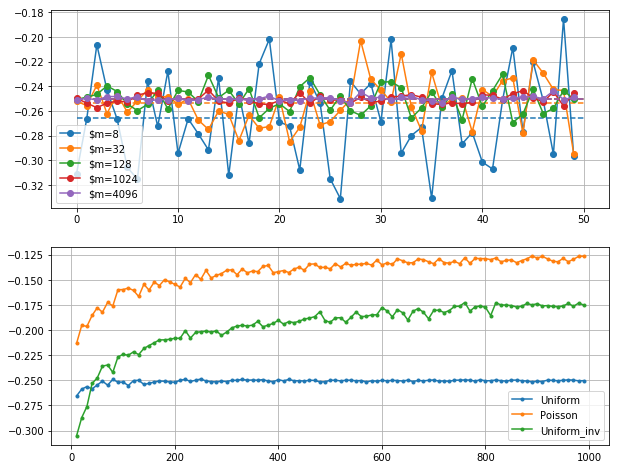

In [108]:
# for k in range(10):
#     X = numpy.random.random(size=10)
#     print('X: ', X)
#     print('H: ', entropy_cdf(X))
#
fg = plt.figure(figsize=(10,8))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
ax1.grid()
ax2.grid()
N=50
Ms = [8, 32, 128, 1024, 4096]
mus = numpy.zeros(len(Ms))
for k,m in enumerate(Ms):
    #
    entropies_uniform = [entropy_cdf(numpy.random.random(m)) for k in range(N)]
    #
    
    #
    ln, = ax1.plot(entropies_uniform, ls='-', marker='o', label='$m={}'.format(m))
    clr = ln.get_color()
    #
    mus[k] = numpy.mean(entropies_uniform)
    ax1.plot([0,N], mus[k]*numpy.ones(2), ls='--', marker='', color=clr)
#
ax1.legend(loc=0)
#ax2.plot(Ms, mus, ls='-', marker='o')
#
Hs_u = numpy.array([[m, numpy.mean([entropy_cdf(numpy.random.random(size=m)) 
                                  for k in range(N)])] for m in range(10, 1000, 10)])
Hs_p = numpy.array([[m, numpy.mean([entropy_cdf(numpy.random.poisson(1., size=m)) 
                                  for k in range(N)])] for m in range(10, 1000, 10)])


ax2.plot(*Hs_u.T, ls='-', marker='.', label='Uniform')
ax2.plot(*Hs_p.T, ls='-', marker='.', label='Poisson')
#
ax2.plot(*numpy.array([[m, numpy.mean([entropy_cdf(numpy.random.poisson(1., size=m), invert=True) 
                                  for k in range(N)])] for m in range(10, 1000, 10)]).T ,
         ls='-', marker='.', label='Uniform_inv')
#
ax2.legend(loc=0)


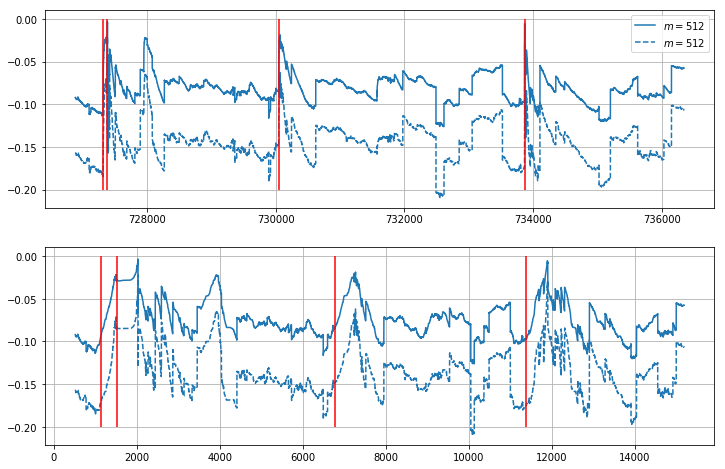

In [138]:
# Now, compute running entropy of interval sequence for various m:
#
#eq_intervals = numpy.diff(catalog['event_date_float'])
fg = plt.figure(figsize=(12,8))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
ax1.grid()
ax2.grid()
#
ax1.vlines(M7s['event_date_float'], -.2, 0., color='r', zorder=11)
#
# TODO: check this to see if it's right:
ax2.vlines(numpy.arange(len(eq_intervals))[ix_m7[1:]], -.2, 0., color='r', zorder=11)


#for m in ( 128, 256, 1024):
for m in ( 512,):
    H_intervals = [entropy_cdf(eq_intervals[k:k+m]) for k,x in enumerate(eq_intervals[m:])]
    H_intervals_inv = [entropy_cdf(eq_intervals[k:k+m], invert=True) for k,x in enumerate(eq_intervals[m:])]
    #
    ln1, = ax1.plot(catalog['event_date_float'][1+m:], H_intervals, ls='-', marker='', label='$m={}$'.format(m))
    clr = ln1.get_color()
    ax1.plot(catalog['event_date_float'][1+m:], H_intervals_inv, color=clr, ls='--', marker='', label='$m={}$'.format(m))
    #
    ln2, = ax2.plot((1+m)+numpy.arange(len(H_intervals_inv)), H_intervals, color=clr,
                                 ls='-', marker='', label='$m={}$'.format(m))
    ax2.plot((1+m)+numpy.arange(len(H_intervals_inv)), H_intervals_inv, color=clr,
                                 ls='--', marker='', label='$m={}$'.format(m))
    #break
#
ax1.legend(loc=0)